## ResNet with Pytorch

In [ ]:
!pip install torchview

In [3]:
import gc
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchview import draw_graph
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Loading train, test and valid data

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [ ]:
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Residual Block

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.block1(x)
        out = self.block2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


In [13]:
x = torch.randn(1,3,224,224)
downsample = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=1, stride=1),
                nn.BatchNorm2d(32),
            )
model = ResidualBlock(3, 32, downsample=downsample)
print('ResidualBlock Output shape : ',model(x).shape)

ResidualBlock Output shape :  torch.Size([1, 32, 224, 224])


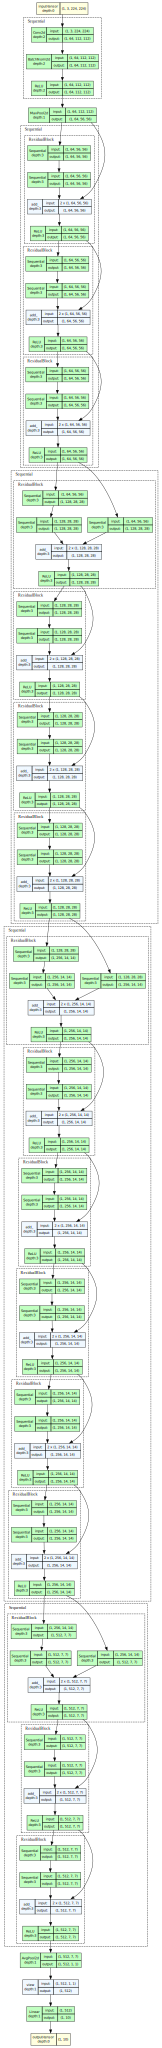

In [20]:
architecture = 'ResidualBlock'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

## ResNet model

In [16]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        
        self.layer0 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [17]:
x = torch.randn(1,3,224,224)
model = ResNet(ResidualBlock, [3, 4, 6, 3])
print('ResNet Output shape : ',model(x).shape)

ResNet Output shape :  torch.Size([1, 10])


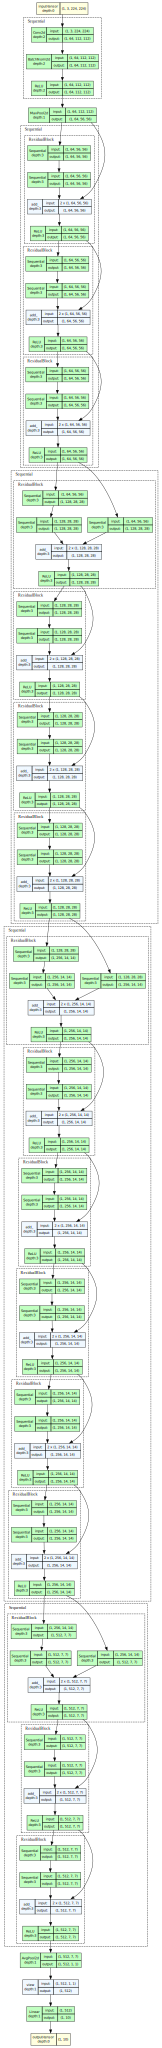

In [19]:
architecture = 'ResNet'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

## Hyperparameters, optimizer and criterion

In [ ]:
num_classes = 100
num_epochs = 10
learning_rate = 0.0001


model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001) 

## Test model

In [ ]:
input_tensor = torch.rand((1, 3, 224, 224), device=device)
output_tensor = model(input_tensor)
print(output_tensor.shape)

## Training model

In [ ]:
# Train the model
total_step = len(train_loader)
print(total_step)

In [ ]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
    
        images = images.to(device)
        labels = labels.to(device)
        
     
        outputs = model(images)
        loss = criterion(outputs, labels)
        
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print (f"Epoch [{epoch+1}/{num_epochs}]\tLoss: {loss.item():.4f}", end="\t")
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
    print(f"valid accuracy : {correct / total}") 

## Testing model

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
    
print(f"Accuracy of test images : {100 * correct / total} %") 